**1/14/21**

The purpose of this notebook is to analyze human proteins I identify and see which are significantly differentially abundant based on BV status.

In [1]:
from elliot_utils import *
from scipy import stats

In [2]:
analysisPath = Path.cwd().joinpath('analysis_files/human_analysis/')
figPath = Path.cwd().joinpath('figures/human_analysis/')

In [3]:
results = getOrderedFiles(HYBRID_RESULTS, '.tsv')
dbs = getOrderedFiles(HYBRID_DB, '.fasta')
refs = [ProtRef(x, disallowRepeats=False) for x in dbs]
hPeps = getFilteredPeptides(results, 'human')
hPeps = getVerifiedPeptides(HUMAN_PEPTIDES_FILE)

In [4]:
bPeps = getVerifiedPeptides(BACTERIAL_PEPTIDES_FILE)

In [5]:
# Get a dictionary of all the human proteins identified by Hybrid_Sample-Matched searches
humanProteins = {} #key=protID, value=protein object

In [6]:
for i in range(len(results)):
    ref = refs[i]
    res = results[i]
    with res.open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if row[PEPTIDE] in hPeps and protType == 'human':
                hits = getProteinHitList(row, 'human')
                for hit in hits:
                    if not hit in humanProteins.keys():
                        humanProteins[hit] = ref.getProt(hit)

In [7]:
# Get the transformed relative abundance for each human protein across all the samples
sampleTotals = [0 for x in range(len(SAMPLE_NAMES))] # Total number of significant human PSMs for each sample.
allTotals = [0 for x in range(len(SAMPLE_NAMES))] # Total significant human & bacterial PSMs for each sample.
humanCounts = {} #key=protID, value=spectral count of the protein in each sample
for p in humanProteins.keys():
    humanCounts[p] = [0 for x in range(len(SAMPLE_NAMES))]

In [17]:
for i in range(len(results)):
    with results[i].open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if row[PEPTIDE] in hPeps and protType == 'human':
                sampleTotals[i] += 1
                hits = getProteinHitList(row, 'human')
                humanCounts[hits[0]][i] += 1
            if (row[PEPTIDE] in hPeps and protType == 'human') or (row[PEPTIDE] in bPeps and protType == 'bacteria'):
                allTotals[i] += 1

In [18]:
# Returns true if all the numbers in the list are 0, false otherwise
def allZeros(numList):
    for num in numList:
        if not num == 0:
            return False
    return True

# Returns the mean of the array
def mean(numList):
    return sum(numList) / len(numList)

In [19]:
# Separate counts into BV+ and BV-, then log-transform them. Also gather total spectra for each protein
totalCounts = {} #key=protID, value=sum of spectral counts across all samples
bvPlusCounts = {} #key=protID, value=list of counts in BV+ samples
bvMinusCounts = {} #key=protID, value=list of counts in BV- samples
bvPlusAbundance = {} #key=protID, value=list of abundances in BV+ samples
bvMinusAbundance = {} #key=protID, value=list of abundances in BV- samples
bvPlusTransformed = {} #key=protID, value=list of transformed abundances in BV+ samples
bvMinusTransformed = {} #key=protID, value=list of transformed abundances in BV- samples
bvPlusStdv = {} #key=protID, value=standard deviation of transformed abundances in BV+ samples
bvMinusStdv = {} #key=protID, value=standard deviation of transformed abundances in BV+ samples

In [20]:
analyzedHumanProteins = []
for p in humanProteins.keys():
    if allZeros(humanCounts[p]): #Ignore proteins that were never hit
        continue
    analyzedHumanProteins.append(p)
    bvPlusCounts[p] = []
    bvMinusCounts[p] = []
    bvPlusAbundance[p] = []
    bvMinusAbundance[p] = []
    bvPlusTransformed[p] = []
    bvMinusTransformed[p] = []
    bvPlusStdv[p] = None
    bvMinusStdv[p] = None
    totalCounts[p] = 0

In [21]:
for i in range(len(SAMPLE_NAMES)):
    for p in analyzedHumanProteins:
        totalCounts[p] += humanCounts[p][i]
        if BV_STATUS[i] == '+':
            bvPlusCounts[p].append(humanCounts[p][i])
            bvPlusAbundance[p].append(humanCounts[p][i] / sampleTotals[i])
            bvPlusTransformed[p].append(math.log2(1 + (humanCounts[p][i] / sampleTotals[i])))
        else:
            bvMinusCounts[p].append(humanCounts[p][i])
            bvMinusAbundance[p].append(humanCounts[p][i] / sampleTotals[i])
            bvMinusTransformed[p].append(math.log2(1 + (humanCounts[p][i] / sampleTotals[i])))
for p in analyzedHumanProteins:
    bvPlusStdv[p] = stats.tstd(bvPlusTransformed[p])
    bvMinusStdv[p] = stats.tstd(bvMinusTransformed[p])

In [22]:
# Test whether the proteins are significantly differentially abundant using the mann-whitney U test
pvals = {} #key=protID, value=p-value of mann-whitney U test

In [23]:
for p in analyzedHumanProteins:
    negData = bvMinusTransformed[p]
    posData = bvPlusTransformed[p]
    res = stats.mannwhitneyu(bvMinusTransformed[p], bvPlusTransformed[p])
    pVal = res.pvalue
    pvals[p] = pVal

In [24]:
with analysisPath.joinpath('differential_proteins_human_v3.csv').open(mode='w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Protein', 'Total', 'p-value', 'BV- Avg Count', 'BV- Avg Transformed Abundance', 'BV- StDev', 'BV+ Avg Count', 'BV+ Avg Transformed Abundance', 'BV+ StDev', 'delta'])
    for p in analyzedHumanProteins:
        writer.writerow([humanProteins[p].name, str(totalCounts[p]), str(pvals[p]), str(mean(bvMinusCounts[p])), str(mean(bvMinusTransformed[p])), str(bvMinusStdv[p]), str(mean(bvPlusCounts[p])), str(mean(bvPlusTransformed[p])), str(bvPlusStdv[p]), str(mean(bvPlusCounts[p]) - mean(bvMinusCounts[p]))])

In [40]:
# Make a volcano plot where Y-axis is -log10(pval) and x axis is log2 BV+ abundance / BV- abundance
log10pvals = []
log2foldchanges = []
abundanceDifferences = []
labels = []
increased = 0
sigIncreased = 0
decreased = 0
sigDecreased = 0
for p in analyzedHumanProteins:
    bvplusMean = mean(bvPlusAbundance[p])
    bvminusMean = mean(bvMinusAbundance[p])
    abundanceDifferences.append(bvplusMean - bvminusMean)
    if bvplusMean > bvminusMean:
        increased += 1
    elif bvminusMean > bvplusMean:
        decreased += 1
    if bvplusMean == 0: #impute minimum values
        bvplusMean = 1e-6
    if bvminusMean == 0:
        bvminusMean = 1e-6
    log10pvals.append(math.log10(pvals[p]) * -1)
    log2foldchanges.append(math.log2(bvplusMean / bvminusMean))
    if pvals[p] > 0.01:
        labels.append('Not Significantly Different')
    elif bvplusMean > bvminusMean:
        labels.append('Higher Abundance in BV')
        sigIncreased += 1
    else:
        labels.append('Lower Abundance in BV')
        sigDecreased += 1
print(f'Higher abundance human proteins: {str(increased)}')
print(f'Significantly higher human proteins: {str(sigIncreased)}')
print(f'Lower abundance human proteins: {str(decreased)}')
print(f'Significantly lower human proteins: {str(sigDecreased)}')

Higher abundance human proteins: 499
Significantly higher human proteins: 14
Lower abundance human proteins: 661
Significantly lower human proteins: 110


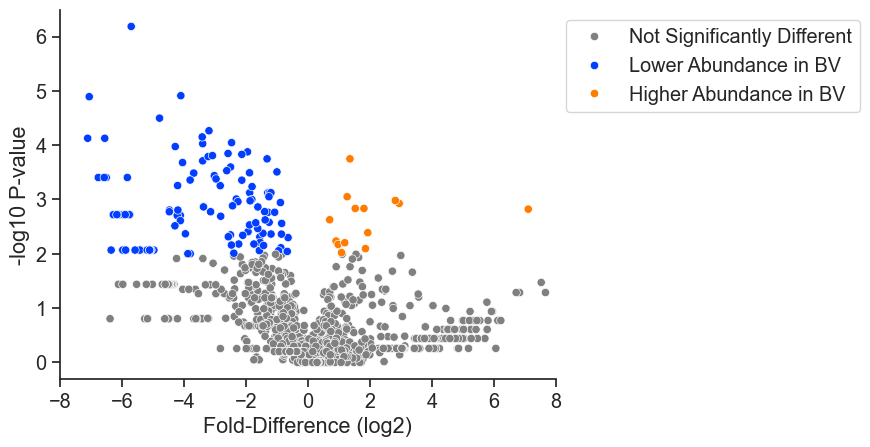

In [41]:
plot = sns.scatterplot(data=pd.DataFrame({'p-vals':log10pvals, 'change':log2foldchanges, 'type':labels}), x='change', y='p-vals', hue='type', palette=['gray', sns.color_palette('bright')[0], sns.color_palette('bright')[1]])
plot.set(xlim=(-8, 8), xlabel='Fold-Difference (log2)', ylabel='-log10 P-value')
sns.despine()
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
saveFig(plot, figPath.joinpath('volcano_plot_human_proteome_normalization.png'))

In [18]:
# How many human proteins were observed in BV- vs BV+ samples?
plusUniques = 0
minusUniques = 0
for p in analyzedHumanProteins:
    if sum(bvPlusCounts[p]) > 0:
        plusUniques += 1
    if sum(bvMinusCounts[p]) > 0:
        minusUniques += 1
print(f'Unique human proteins in BV+ samples: {str(plusUniques)}')
print(f'Unique human proteins in BV- samples: {str(minusUniques)}')

Unique human proteins in BV+ samples: 1061
Unique human proteins in BV- samples: 1015


Sum of all abundance differences: 1.6276585114438635e-17


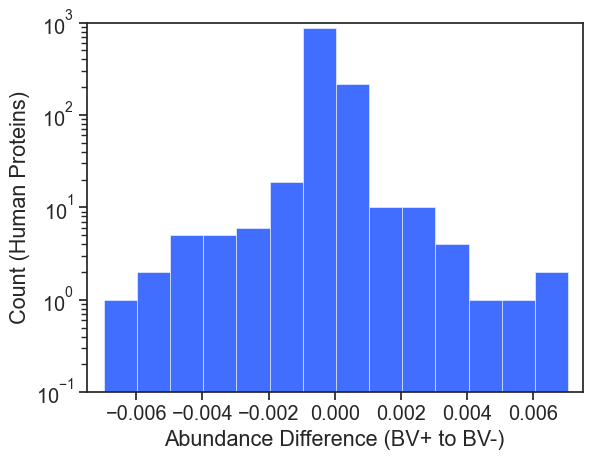

In [20]:
plot = sns.histplot(data=pd.DataFrame({'Abundance Difference':abundanceDifferences}), x='Abundance Difference', binwidth=0.001)
plot.set(yscale='log', xlim=(-0.0075,0.0075), ylim=(0.1, 1000), ylabel='Count (Human Proteins)', xlabel='Abundance Difference (BV+ to BV-)')
print(f'Sum of all abundance differences: {str(sum(abundanceDifferences))}')
saveFig(plot, figPath.joinpath('abundance_difference_histogram.png'))

In [21]:
# Make a plot for all human proteins showing the relationship between the average number of spectra matching a protein and its abundance difference (BV+ to BV-)
avgCounts = []
abundanceDifferences = []
highest = 0
protein = ''
for p in bvPlusCounts.keys():
    if (sum(bvPlusCounts[p]) + sum(bvMinusCounts[p])) / (len(bvPlusCounts[p]) + len(bvMinusCounts[p])) > highest:
        highest = (sum(bvPlusCounts[p]) + sum(bvMinusCounts[p])) / (len(bvPlusCounts[p]) + len(bvMinusCounts[p]))
        protein = p
    avgCounts.append(math.log((sum(bvPlusCounts[p]) + sum(bvMinusCounts[p])) / (len(bvPlusCounts[p]) + len(bvMinusCounts[p]))))
    abundanceDifferences.append((mean(bvPlusAbundance[p]) - mean(bvMinusAbundance[p])))
print(protein)

sp|P13646|K1C13_HUMAN


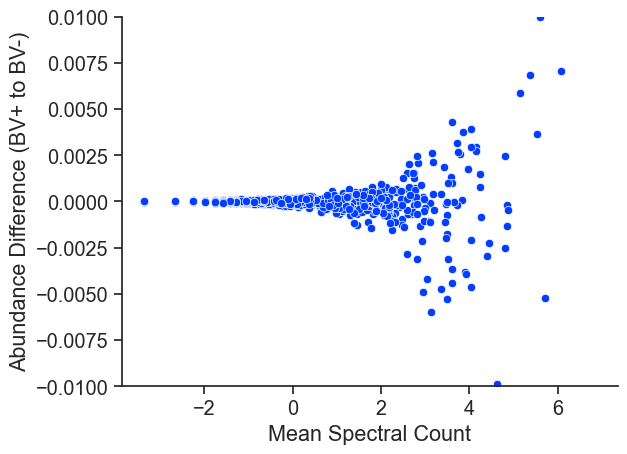

In [22]:
plot = sns.scatterplot(data=pd.DataFrame({'Mean Spectral Count':avgCounts, 'Abundance Difference (BV+ to BV-)':abundanceDifferences}), x='Mean Spectral Count', y='Abundance Difference (BV+ to BV-)')
plot.set(ylim=(-0.01, 0.01))
sns.despine()

In [26]:
bvPlusAbundanceProteome = {} #key=protID, value=list of abundances in BV+ samples
bvMinusAbundanceProteome = {} #key=protID, value=list of abundances in BV- samples
bvPlusAbundanceProteomeLog = {} #key=protID, value=list of log-transformed abundances in BV+ samples
bvMinusAbundanceProteomeLog = {} #key=protID, value=list of log-transformed abundances in BV- samples

In [27]:
for p in analyzedHumanProteins:
    bvPlusAbundanceProteome[p] = []
    bvMinusAbundanceProteome[p] = []
    bvPlusAbundanceProteomeLog[p] = []
    bvMinusAbundanceProteomeLog[p] = []

In [28]:
for i in range(len(SAMPLE_NAMES)):
    for p in analyzedHumanProteins:
        if BV_STATUS[i] == '+':
            bvPlusAbundanceProteome[p].append(humanCounts[p][i] / allTotals[i])
            bvPlusAbundanceProteomeLog[p].append(math.log2(1 + (humanCounts[p][i] / allTotals[i])))
        else:
            bvMinusAbundanceProteome[p].append(humanCounts[p][i] / allTotals[i])
            bvMinusAbundanceProteomeLog[p].append(math.log2(1 + (humanCounts[p][i] / allTotals[i])))

In [29]:
# Test whether the proteins are significantly differentially abundant using the mann-whitney U test
pvalsproteome = {} #key=protID, value=p-value of mann-whitney U test

In [30]:
for p in analyzedHumanProteins:
    negData = bvMinusAbundanceProteomeLog[p]
    posData = bvPlusAbundanceProteomeLog[p]
    res = stats.mannwhitneyu(negData, posData)
    pVal = res.pvalue
    pvalsproteome[p] = pVal

In [42]:
# Make a volcano plot where Y-axis is -log10(pval) and x axis is log2 BV+ abundance / BV- abundance for human data normalized to whole proteome
log10pvals = []
log2foldchanges = []
labels = []
increased = 0
sigIncreased = 0
decreased = 0
sigDecreased = 0
for p in analyzedHumanProteins:
    bvplusMean = mean(bvPlusAbundanceProteome[p])
    bvminusMean = mean(bvMinusAbundanceProteome[p])
    if bvplusMean > bvminusMean:
        increased += 1
    elif bvminusMean > bvplusMean:
        decreased += 1
    if bvplusMean == 0: #impute minimum values
        bvplusMean = 1e-6
    if bvminusMean == 0:
        bvminusMean = 1e-6
    log10pvals.append(math.log10(pvalsproteome[p]) * -1)
    log2foldchanges.append(math.log2(bvplusMean / bvminusMean))
    if pvalsproteome[p] > 0.01:
        labels.append('Not Significantly Different')
    elif bvplusMean > bvminusMean:
        labels.append('Higher Abundance in BV')
        sigIncreased += 1
    elif bvminusMean > bvplusMean:
        labels.append('Lower Abundance in BV')
        sigDecreased += 1
print(f'Higher abundance human proteins: {str(increased)}')
print(f'Significantly higher abundance human proteins: {str(sigIncreased)}')
print(f'Lower abundance human proteins: {str(decreased)}')
print(f'Significantly lower abundance human proteins: {str(sigDecreased)}')

Higher abundance human proteins: 452
Significantly higher abundance human proteins: 8
Lower abundance human proteins: 708
Significantly lower abundance human proteins: 120


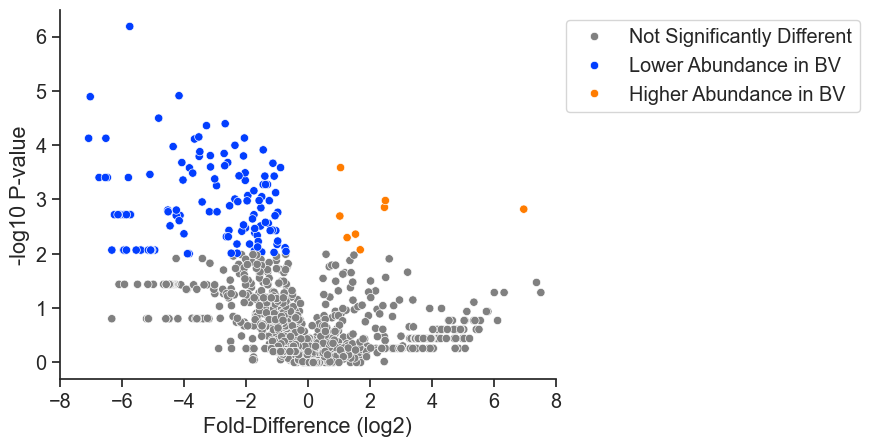

In [43]:
plot = sns.scatterplot(data=pd.DataFrame({'p-vals':log10pvals, 'change':log2foldchanges, 'type':labels}), x='change', y='p-vals', hue='type', palette=['gray', sns.color_palette('bright')[0], sns.color_palette('bright')[1]])
plot.set(xlim=(-8, 8), xlabel='Fold-Difference (log2)', ylabel='-log10 P-value')
sns.despine()
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
saveFig(plot, figPath.joinpath('volcano_plot_total_proteome_normalization.png'))

In [39]:
# Perform the same analysis with GO annotations associated with the proteins
annotations = {} #key=protein ID, value=list of GO numbers associated with the protein
for p in humanProteins.keys():
    annotations[p] = []

In [56]:
annotationFile = pd.read_csv(Path.cwd().joinpath('analysis_files/functional_analysis/eggnog_annotations_human.tsv'), sep='\t')
annotationCounts = {'unannotated':[0 for x in range(len(SAMPLE_NAMES))]} #key=GO number, value=list of spectral counts associated with that GO number in each sample

In [57]:
# Get protein -> annotations associations, and also pull out all the annotations associated with all human proteins into another dict
for index, row in annotationFile.iterrows():
    prot = row['query']
    gostring = row['GOs']
    if gostring == '-':
        annotations[prot] = ['unannotated']
    else:
        goList = gostring.split(',')
        annotations[prot] = goList
        for go in goList:
            annotationCounts[go] = [0 for x in range(len(SAMPLE_NAMES))]
for p in annotations.keys():
    if len(annotations[p]) == 0:
        annotations[p] = ['unannotated']

In [58]:
# Get spectral counts for annotations
for i in range(len(results)):
    with results[i].open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if row[PEPTIDE] in hPeps and protType == 'human':
                hits = getProteinHitList(row, 'human')
                for hit in hits:
                    for go in annotations[hit]:
                        annotationCounts[go][i] += 1

In [59]:
# Separate annotation counts into BV+ and BV-, then log-transform them
bvPlusAnotCounts = {} #key=protID, value=list of counts in BV+ samples
bvMinusAnotCounts = {} #key=protID, value=list of counts in BV- samples
bvPlusAnotTransformed = {} #key=protID, value=list of transformed abundances in BV+ samples
bvMinusAnotTransformed = {} #key=protID, value=list of transformed abundances in BV- samples

In [62]:
for a in annotationCounts.keys():
    if allZeros(annotationCounts[a]): #Ignore annotations that were never hit
        continue
    bvPlusAnotCounts[a] = []
    bvMinusAnotCounts[a] = []
    bvPlusAnotTransformed[a] = []
    bvMinusAnotTransformed[a] = []

In [63]:
for i in range(len(SAMPLE_NAMES)):
    for a in bvPlusAnotCounts.keys():
        if BV_STATUS[i] == '+':
            bvPlusAnotCounts[a].append(annotationCounts[a][i])
            bvPlusAnotTransformed[a].append(math.log2(1 + (annotationCounts[a][i] / sampleTotals[i])))
        else:
            bvMinusAnotCounts[a].append(annotationCounts[a][i])
            bvMinusAnotTransformed[a].append(math.log2(1 + (annotationCounts[a][i] / sampleTotals[i])))

In [71]:
# Test whether the proteins are significantly differentially abundant using the mann-whitney U test
annotpvals = {} #key=protID, value=p-value of mann-whitney U test

In [72]:
for a in bvPlusAnotCounts.keys():
    negData = bvMinusAnotTransformed[a]
    posData = bvPlusAnotTransformed[a]
    res = stats.mannwhitneyu(bvMinusAnotTransformed[a], bvPlusAnotTransformed[a])
    pVal = res.pvalue
    annotpvals[a] = pVal

In [64]:
goref = GoRef(Path.cwd().joinpath('analysis_files/go.obo'))

In [73]:
with analysisPath.joinpath('differential_annotations_human.csv').open(mode='w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['GO', 'Annotation', 'p-value', 'BV- Avg Count', 'BV- Avg Transformed Abundance', 'BV+ Avg Count', 'BV+ Avg Transformed Abundance'])
    for a in bvPlusAnotCounts.keys():
        function = a if a == 'unannotated' else goref.getFunc(a)
        writer.writerow([a, function, str(annotpvals[a]), str(mean(bvMinusAnotCounts[a])), str(mean(bvMinusAnotTransformed[a])), str(mean(bvPlusAnotCounts[a])), str(mean(bvPlusAnotTransformed[a]))])

How many human PSMs do I get in BV- vs. BV+ samples? How many different human proteins, on average, do I see in BV- vs. BV+ samples?

In [8]:
psmCounts = []
protCounts = []

In [9]:
# Count PSMs and proteins by BV status
for i in range(len(results)):
    with results[i].open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        psmCount = 0
        allHitProts = set()
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if row[PEPTIDE] in hPeps and protType == 'human':
                psmCount += 1
                hits = getProteinHitList(row, 'human')
                for hit in hits:
                    allHitProts.add(hit)
        psmCounts.append(psmCount)
        protCounts.append(len(allHitProts))

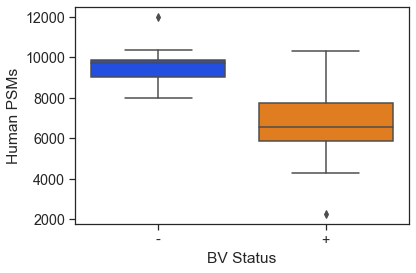

In [14]:
psmDF = pd.DataFrame({'Human PSMs':psmCounts, 'BV Status':BV_STATUS})
psmsPlot = sns.boxplot(data=psmDF, x='BV Status', y='Human PSMs')
saveFig(psmsPlot, figPath.joinpath('psms_by_bv.png'))

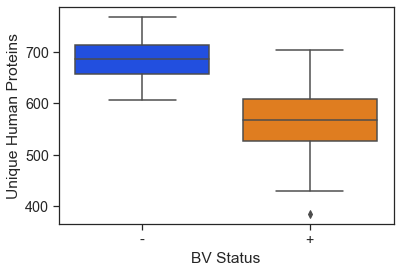

In [15]:
protDF = pd.DataFrame({'Unique Human Proteins':protCounts, 'BV Status':BV_STATUS})
protPlot = sns.boxplot(data=protDF, x='BV Status', y='Unique Human Proteins')
saveFig(protPlot, figPath.joinpath('prots_by_bv.png'))